(50, 2)


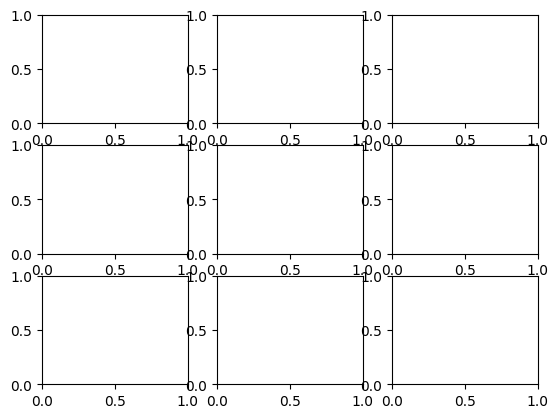

In [63]:
#!/usr/bin/python3
import numpy as np
import bisect as bi
from mpl_toolkits import mplot3d
import matplotlib.pyplot as pt
import control as ct
from control.matlab import *
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
pt.close()
fig, ax = pt.subplots(3,3)

# Helpers %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def edInt(a,s,b):
    return np.linspace(a,b,int(np.floor((b-a)/s)))

# Used for poorman's nearest-neighbour regular-grid interpolation
def idx(aList, val):
    i = bi.bisect(aList, val) # right
    if i <= 0: # first
        pass
    elif len(aList) == i: # last
        i -= 1
    elif val - aList[i-1] < aList[i] - val: # left
        i -= 1
    return i

def lookup(aList, vals):
    """result is undefined if vals is not sorted"""
    indices = []
    v = vals
    if type(v) in [int,float,np.int64,np.float64]:
        v = [v]
    for k in np.sort(v):
        indices.append(idx(aList,k))
    return np.array(indices, dtype=np.uint32)

# Settings %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
dt = .2; infStValInc = 300; nullCtr = 0; tf = 10
T = edInt(0, dt, tf) # time horizon
U = edInt(-50, 1, 50)  # admissible controls
x1, x2 = np.meshgrid(edInt(-10,2,110), edInt(-10,2,110)) # admissible states
a1 = a2 = .01
b1 = b2 = .005
A = np.array([[-a1, b1], [b2, -a2]])
B1 = np.array([1, 0])
B2 = np.array([0, 1])

# System constants
N = T.size
Q = np.array([[500, 0], [0, 100]])
R = 0.05
z0 = np.array([0, 23]) # initial state (only for simulation)
#w = np.array([50, 50]) # reference (or set-point)

x0 = np.zeros((N+1, 2))
x0[0,:] = [20,20]
final_x0 = 80
step_x0 = 0.05

for k in range(N):

    current_target = final_x0    
    dist = current_target - x0[k, 0]
    change = dist * step_x0

    x0[k+1, 0] = x0[k, 0] + change
    x0[k+1, 1] = x0[k, 1] + change

w = x0[1:, :]


# ref_x1_traj = w[N-1,0]
# ref_x2_traj = w[N-1,1]

# erro_x1_end = x1 - ref_x1_traj
# erro_x2_end = x2 - ref_x2_traj

custo_final = x1**2 * Q[0,0] + x2**2 * Q[1,1]

V1 = np.zeros((x2.shape[0], x1.shape[1], N))
V2 = np.zeros((x2.shape[0], x1.shape[1], N))

V1[:,:,N-1] = custo_final
V2[:,:,N-1] = custo_final


err_x1 = np.zeros((x2.shape[0], x1.shape[1]))
err_x2 = err_x1.copy()
depth=0 # for value snapshots

u_opt1 = np.zeros((x2.shape[0], x1.shape[1], N))
u_opt2 = np.zeros((x2.shape[0], x1.shape[1], N))

print(x0[1:, :].shape)

In [64]:
for k in range(N-1,depth,-1):
    x1_err = x1
    x2_err = x2
    L = (x1**2 * Q[0,0]) + (x2**2 * Q[1,1])
    if (k%10)==0:
        print(f"Processing time step {k}")
    for i in range(0,x2.shape[0]):
        for j in range(0,x1.shape[1]):
            e_val = np.array([x1[i,j], x2[i,j]])
            L_val = L[i,j]

            dx1_dt = A[0,0]*e_val[0] + A[0,1]*e_val[1] + B1[0]*U
            dx2_dt = A[1,0]*e_val[0] + A[1,1]*e_val[1] + B1[1]*U
            # dx1_dt = A[0,0]*x_err[0] + A[0,1]*x_err[1] + B1[0]*U
            # dx2_dt = A[1,0]*x_err[0] + A[1,1]*x_err[1] + B1[1]*U

            # forward Euler TANK 1
            err_next_1 = e_val[0] + dx1_dt * dt
            err_next_2 = e_val[1] + dx2_dt * dt  
            i_new_x1 = lookup(x1[0,:],err_next_1)      
            i_new_x2 = lookup(x2[:,0],err_next_2)

            i_U = range(0,U.size)
            err_x1[i,j] = np.max(err_next_1) # truncated dynamics
            err_x2[i,j] = np.max(err_next_2)

            #forward Euler TANK 2
            dx1_dt_2 = A[0,0]*e_val[0] + A[0,1]*e_val[1] + B2[0]*U
            dx2_dt_2 = A[1,0]*e_val[0] + A[1,1]*e_val[1] + B2[1]*U
            # dx1_dt_2 = A[0,0]*x_err[0] + A[0,1]*x_err[1] + B2[0]*U
            # dx2_dt_2 = A[1,0]*x_err[0] + A[1,1]*x_err[1] + B2[1]*U
            x1_next_abs_2 = e_val[0] + dx1_dt_2 * dt
            x2_next_abs_2 = e_val[1] + dx2_dt_2 * dt  
            i_new_x1_2 = lookup(x1[0,:],x1_next_abs_2)      
            i_new_x2_2 = lookup(x2[:,0],x2_next_abs_2)

            i_U_2 = range(0,U.size)
            err_x1[i,j] = np.max(x1_next_abs_2) # truncated dynamics
            err_x2[i,j] = np.max(x2_next_abs_2)
            # make sure admissible state/control exists TANK 1
            if (i_new_x1.size != 0 and i_new_x2.size != 0):
                V_next = V1[i_new_x2,i_new_x1,k]
                J_total = L_val + V_next + (R * (U**2))
                i_U = np.argmin(J_total)
                V1[i,j,k-1] = J_total[i_U]
            else:
                i_U, V1[i,j,k-1] = lookup(U,nullCtr)[0][0], V1[i,j,k] + infStValInc
            u_opt1[i,j,k-1] = U[i_U] # i_U should be a singleton list

            # make sure admissible state/control exists TANK 2
            if (i_new_x1_2.size != 0 and i_new_x2_2.size != 0):
                V_next_2 = V2[i_new_x2_2,i_new_x1_2,k]
                J_total_2 = L_val + V_next_2 + (R * (U**2))
                i_U_2 = np.argmin(J_total_2)
                V2[i,j,k-1] = J_total_2[i_U_2]
            else:
                i_U_2, V2[i,j,k-1] = lookup(U,nullCtr)[0][0], V2[i,j,k] + infStValInc
            u_opt2[i,j,k-1] = U[i_U_2] # i_U should be a singleton list




Processing time step 40
Processing time step 30
Processing time step 20
Processing time step 10


k     | Erro T1    | Custo Passado (Modo1) | Custo Futuro (Modo2) | TOTAL          
--------------------------------------------------------------------------------
0     | -23.00     | 264605.6             | 2500144.3            | 2764749.9      
1     | -16.64     | 403912.9             | 2451670.4            | 2855583.3      
2     | -10.15     | 458671.7             | 2403687.9            | 2862359.6      
3     | -3.54      | 471740.0             | 363667.3             | 835407.3       
4     | -2.88      | 487365.2             | 359761.4             | 847126.7       
Great Instant of Comutação encontrado: k=5 (t=1.02s)


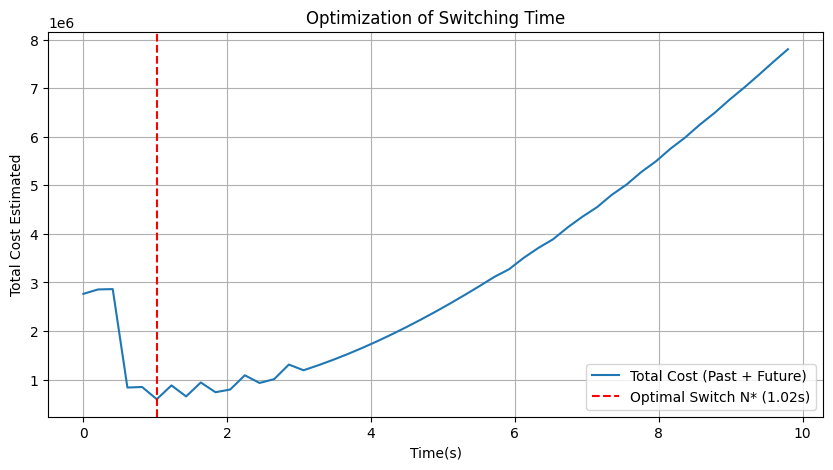

In [ ]:
z_traj = np.zeros((N,2))
z_traj[0,:] = z0
sum_cost = np.zeros(N)
cost = 0
for k in range(N-1):
    x_err = z_traj[k,:] - w[k]
    e1_val = np.clip(x_err[0], x1[0,0], x1[0,-1])
    e2_val = np.clip(x_err[1], x2[0,0], x2[-1,0])
    i_x1 = lookup(x1[0,:],e1_val)[0]
    i_x2 = lookup(x2[:,0],e2_val)[0]
    u_val = u_opt1[i_x2,i_x1,k]
    stage_cost = (x_err.T@Q@x_err).item() + R*u_val**2 
    cost += stage_cost
    sum_cost[k] = cost

    dx = A@z_traj[k,:] + B1*u_val
    z_traj[k+1,:] = z_traj[k,:] + dx*dt

total_cost = np.zeros(N-1)

for k in range(N-1):
    futur_err = z_traj[k,:] - w[k]
    e1_val = np.clip(futur_err[0], x1[0,0], x1[0,-1])
    e2_val = np.clip(futur_err[1], x2[0,0], x2[-1,0])
    i_x1 = lookup(x1[0,:],e1_val)[0]
    i_x2 = lookup(x2[:,0],e2_val)[0]
    future_cost = V2[i_x2,i_x1,k]
    total_cost[k] = sum_cost[k] + future_cost

print(f"{'k':<5} | {'Erro T1':<10} | {'Past Cost(Modo1)':<20} | {'Future Cost (Modo2)':<20} | {'TOTAL':<15}")
print("-" * 80)

for k in range(5):
    err_now = z_traj[k,:] - w[k]
    
    c_past = sum_cost[k]
    c_future = total_cost[k] - sum_cost[k] 
    c_total = total_cost[k]
    
    print(f"{k:<5} | {err_now[0]:<10.2f} | {c_past:<20.1f} | {c_future:<20.1f} | {c_total:<15.1f}")


# Only consider valid switching times (avoid last few steps)
valid_range = N-1
cost_optimal = np.argmin(total_cost[:valid_range])
N_start_time = T[cost_optimal]

print(f"Great Instant of Comutação encontrado: k={cost_optimal} (t={N_start_time:.2f}s)")

pt.figure(figsize=(10, 5))
pt.plot(T[:-1], total_cost, label='Total Cost (Past + Future)')
pt.axvline(N_start_time, color='r', linestyle='--', label=f'Optimal Switch N* ({N_start_time:.2f}s)')
pt.xlabel('Time(s)')
pt.ylabel('Total Cost Estimated')
pt.title('Optimization of Switching Time')
pt.legend()
pt.grid(True)
pt.show()

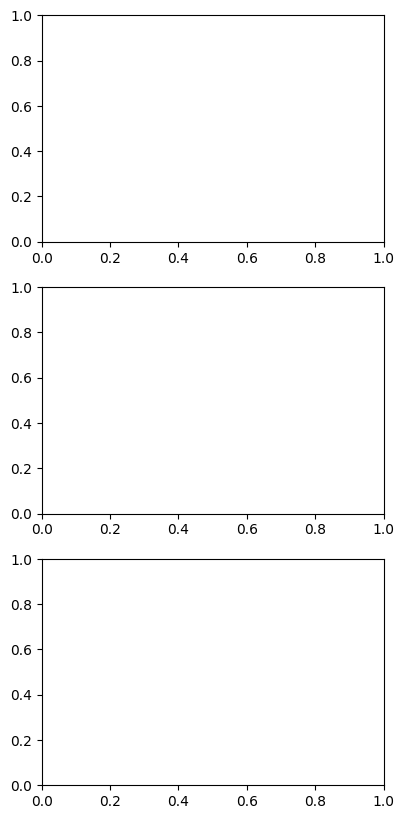

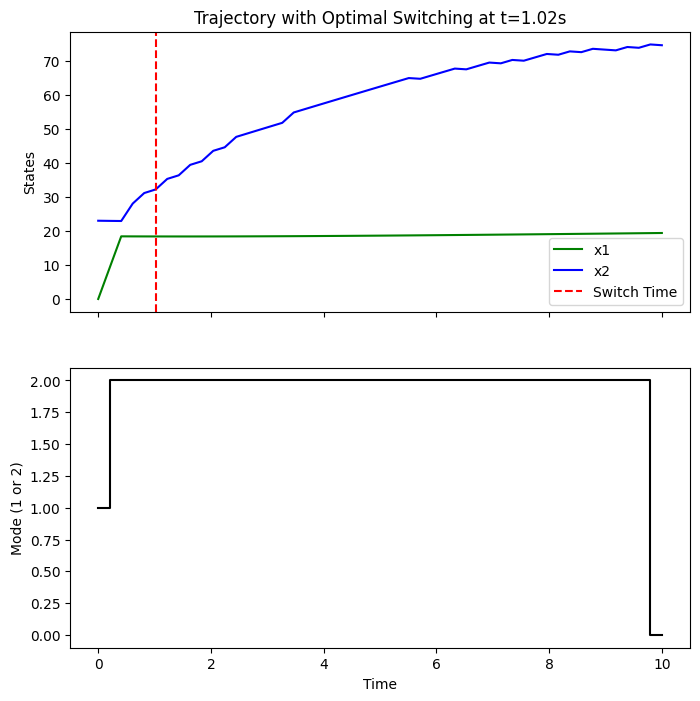

In [66]:
pt.close('all') 
fig = pt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 3)

ax_x1 = fig.add_subplot(gs[0, 0])
ax_x2 = fig.add_subplot(gs[1, 0])
ax_u = fig.add_subplot(gs[2, 0])

# Simulation (from z0 using u_opt(x)) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
z = np.zeros((T.size,2))
z[0,:] = z0
u_final = np.zeros((N))
u1 = np.zeros((T.size))
u2 = np.zeros((T.size))
mode_final = np.zeros((N))
current_mode = 1


for k in range(0,T.size-1):
    error_current = z[k,:] - w[k]
    e1_val = np.clip(error_current[0], x1[0,0], x1[0,-1])
    e2_val = np.clip(error_current[1], x2[0,0], x2[-1,0])
    i_idx = lookup(x2[:,0],e2_val)[0]
    j_jdx = lookup(x1[0,:],e1_val)[0]
    u1[k] = u_opt1[i_idx, j_jdx, k]
    u2[k] = u_opt2[i_idx, j_jdx, k]
    u_curr = 0
    u_val1 = u1[k]
    u_val2 = u2[k]

    if k <= N_start_time:
        u_curr = u_val1
        dx = A@z[k,:] + B1*u_curr
        z[k+1,:] = z[k,:] + dt*(dx)
        current_mode = 1
    else:
        current_mode = 2
        u_curr = u_val2
        dx = A@z[k,:] + B2*u_curr
        z[k+1,:] = z[k,:] + dt*dx

    u_final[k] = u_curr
    mode_final[k] = current_mode
    z[k+1,:] = z[k,:] + dt*dx

# Plot Simples do Resultado
fig, (ax1, ax2) = pt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax1.plot(T, z[:,0], 'g', label='x1')
ax1.plot(T, z[:,1], 'b', label='x2')
ax1.axvline(N_start_time, color='r', linestyle='--', label='Switch Time')
ax1.set_ylabel('States')
ax1.legend()
ax1.set_title(f'Trajectory with Optimal Switching at t={N_start_time:.2f}s')

ax2.step(T, mode_final, 'k')
ax2.set_ylabel('Mode (1 or 2)')
ax2.set_xlabel('Time')
pt.show()
    